<font color = 'blue'>This code will use the power of GPU to accelerate the computation of mandelbrot set. One can only observe the power of GPU when run the similar program without GPU acceleration and then run this code(GPU acclerated) in a same machine so that the machine configuration remain similar. <font><font color = 'red'>This code requires machine with GPU and pycuda and nvcc compiler installed to run. Easiest way to check this code would be to use google colab notebook and use GPU availalbe in google cloud. This should work pretty well there.<font>

In [1]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.8/92.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.0 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1.2-cp311-cp311-linux_x86_64.whl size=660362 sha256=4bf8c0a2f548c76a2efb60e21a2648113d8238360afcda33a761215b4cbb02b1
  Stored in directory: /root/.cache/pip/wheels/76/66/50/c65e6116d7e0e16abe0f7c19b50327f76724ccfefbdc61a1b9
Successfully built pycuda


In [2]:
import numpy as np
import pycuda.autoinit
from pycuda import gpuarray
import matplotlib.pyplot as plt
from pycuda.elementwise import ElementwiseKernel             # This is inbuilt-CUDA kernel to perform pointwise operations.
from time import time

<font color = 'blue'>This code is written from help with Brian Tuomanen's book. Original code is also present [here in github](https://github.com/PacktPublishing/Hands-On-GPU-Programming-with-Python-and-CUDA/blob/master/Chapter03/gpu_mandelbrot0.py). I have made few changes of my own. In this program, testing of whether a given complex number belongs to Mandelbrot set or not is done inside the 'ElementwiseKernel' CUDA function. As this part is the one that involves large number of computation we make use of GPU power to accelerate the performance. We write separate python function later to call this CUDA function and then use the result to make an image of mandelbrot set. Beautiful artistic pattern seen below represents mandelbrot set. <font>

/usr/local/lib/python3.11/dist-packages/google/colab/_variable_inspector.py:27: UserWarning: module in out-of-thread context could not be cleaned up
  globals().clear()




 Time taken to calculate mandelbrot set is:  0.296511173248291  seconds.


 Time taken to make image is:  0.01952505111694336  seconds.




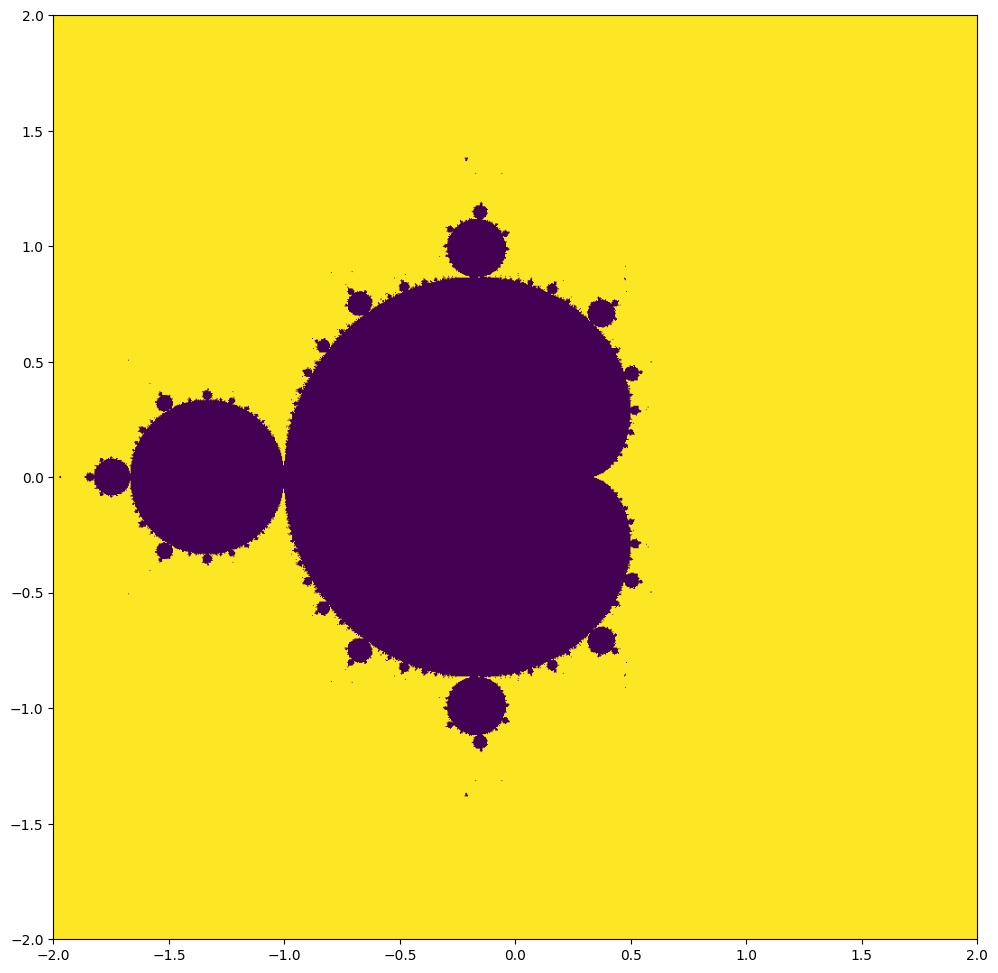

In [5]:
# Below is a inbuilt-CUDA kernal called 'ElementwiseKernel'. Everything written inside () of 'ElementwiseKernel' is written in C/C++ language as that is what CUDA uses to write
# its kernel. First part inside the kernel is input and output variable declaration as pointers. In C/C++ language '*' in front of variable is pointer that refers to the memory
# location. The whole block within this """  """  triple quotes is a C/C++ code block and the last one inside " " is the name of the kernel function. It is OK to name similar to
# the actual python name give to the kernel because insdie the kernel the naming is done in CUDA language so there won't be conflict.

mandelbrot_CUDA_kernel = ElementwiseKernel("pycuda::complex<float> *complex_grid, float *mandelbrot_image, int max_iter, int convergence_radius",
                                           """mandelbrot_image[i] = 0;
pycuda::complex<float> c = complex_grid[i];
pycuda::complex<float> z(0,0);


for(int n = 0; n <= max_iter; n++)
{
z = z*z + c;

if(abs(z) > convergence_radius)
{
mandelbrot_image[i] = 1;
break;
}
}
""", "mandelbrot_CUDA_kernel")

# Defining a python functon which will return Mandelbrot set making use of above CUDA kernel.

def mandelbrotset_test(lower_limit, upper_limit,dimension, max_iteration,  convergence_radius):

  ''' This function will first create a grid of complex numbers. These complex numbers will be tested if they belong to mandelbrot set using ElementwiseKernel defined above.Those
  complex numbers that belong to the set are changed to value 1 else 0. Returns us a mandelbrot set.'''

  x = np.linspace(lower_limit,upper_limit, dimension)
  y = np.linspace(lower_limit, upper_limit, dimension)
  X,Y = np.meshgrid(x, 1j*y)
  Z = np.array(X + Y, dtype = np.complex64)

  Z_to_gpu = gpuarray.to_gpu(Z)
  mandelbrot_image_gpu = gpuarray.empty(shape = Z.shape, dtype = np.float32)
  mandelbrot_CUDA_kernel(Z_to_gpu, mandelbrot_image_gpu, np.int32(max_iteration), np.int32(convergence_radius))    # Calling 'ElementwiseKernel' in-built CUDA function.
  mandelbrot_set = mandelbrot_image_gpu.get()
  return mandelbrot_set

def graph_mandelbrotset(mandel_set):
  ''' Uses mandelbrot set to make a fractal graph.'''
  plt.figure(figsize=(12,12))
  plt.imshow(mandel_set, extent=(-2.0, 2.0, -2.0, 2.0))


def main():
  time1 = time()
  result1 = mandelbrotset_test(-1.5, 1.5,1024,300, 2)
  time2 = time()
  print("\n\n Time taken to calculate mandelbrot set is: ", time2 - time1, " seconds.")

  t1 = time()
  result2 = graph_mandelbrotset(result1)
  t2 = time()
  print("\n\n Time taken to make image is: ", t2 - t1, " seconds.\n\n")

if __name__ == "__main__":
  main()